# Description

We will model a random polynomial using a combination of ReLU functions from scratch

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

In [2]:
import numpy as np

degree = np.random.randint(low=2, high=20)
coefficients = np.random.randn(degree+1)

In [3]:
degree

14

In [4]:
coefficients

array([ 1.23961449,  0.24638097,  0.41391987,  0.85575513, -1.411263  ,
        1.73284534, -1.72200304, -0.82299679,  1.23873588, -1.87528065,
       -0.97206166, -0.09117287, -0.77310077,  1.37780618,  0.24720934])

In [5]:
list(range(degree+1)[::-1])

[14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [6]:
np.random.seed(42)
x = torch.linspace(-1,1,steps=1000)[:None]

powers = list(range(degree+1)[::-1])

x_powers = []

for power in powers:
    temp = x**power
    temp = temp.reshape([len(temp), 1])
    if x_powers==[]:
        x_powers = temp
    else:
        x_powers = torch.cat([x_powers, temp], dim=1)

In [7]:
x_powers.shape

torch.Size([1000, 15])

In [8]:
coefficients.shape

(15,)

In [9]:
y = x_powers @ coefficients

In [10]:
import numpy as np
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape) #scale-> std dev
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

y = add_noise(y, 0.5, 1)

In [11]:
y.shape

torch.Size([1000])

In [12]:
x.shape

torch.Size([1000])

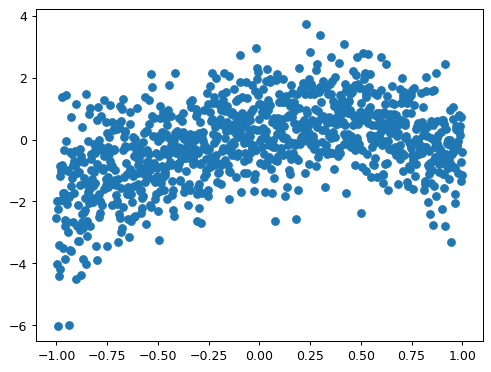

In [13]:
plt.scatter(x, y)

In [14]:
def mse(act, pred): return ((act-pred)**2).mean()

def rectified_linear(m,b,x):
	y = m*x + b
	return torch.clip(y, 0.0)


In [15]:
def multi_relu(w1, w2, x):
    """
    MultiReLU is capable to handling weighted combination of any number of ReLU s possible.
    Parameters:
    - w1 : A matrix of size d * 2, where d is the size of the hidden layer (no of ReLUs we use)
           Every ReLU is a seperate row with the m and b part of its column
    - w2 : These are individual weights to combine the ReLUs plus the bias term
    - x : input variable of size N where N are the no of data points
    """
    
    # Step 1: Add the bias feature in a separate row to make x of size N * 2
    x = x.reshape((len(x), 1))
    ones = torch.ones(x.shape)
    x_bias = torch.cat((x, ones), dim=1)
    
    # Step 2: Matrix multiply x_bias with w1. Apply ReLU
    hidden = x_bias @ w1.T
    hidden_relu = torch.clip(hidden, 0.0)
    
    # Step 3: Add the bias parameter to the hidden
    ones2 = torch.ones((hidden_relu.shape[0], 1))
    hidden_relu_bias = torch.cat((hidden_relu, ones2), dim=1)
    
    # Step 4: Multiply with w2 to combine ReLU s
    y_pred = hidden_relu_bias @ w2
    
    return y_pred.flatten()

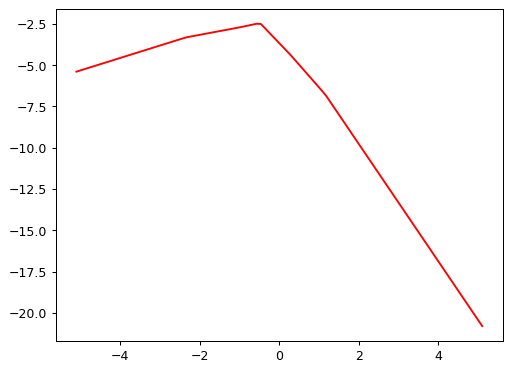

In [16]:
np.random.seed(42)
w1 = np.random.randn(5,2)
w2 = np.random.randn(6,1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

plot_function(partial(multi_relu, w1, w2), min=-5.1, max=5.1)

In [17]:
def compute_mse(w1, w2):
    multi_relu_fixed = partial(multi_relu, w1, w2)
    return mse(multi_relu_fixed(x), y)

### One step of backprop

In [18]:
hidden_dim = degree * 2
w1 = np.random.randn(hidden_dim, 2)
w2 = np.random.randn(hidden_dim + 1, 1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

loss = compute_mse(w1, w2)
loss.backward()

with torch.no_grad(): 
    w1 -= (lr*w1.grad)
    w2 -= (lr*w2.grad)

    w1.grad.zero_()
    w2.grad.zero_()
    
print(f"Loss: {loss:.2f}")

Loss: 25.46


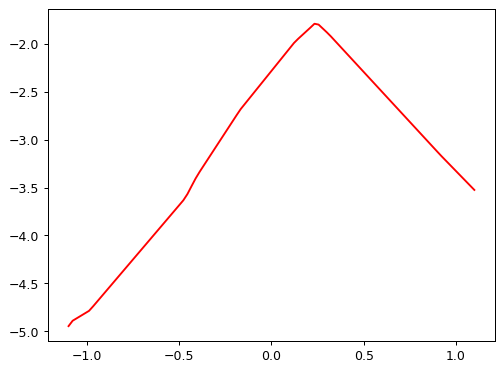

In [19]:
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-1.1, max=1.1)

### Fixed lr

In [20]:
np.random.seed(42)
hidden_dim = degree * 4
w1 = np.random.randn(hidden_dim, 2)
w2 = np.random.randn(hidden_dim + 1, 1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 1.28
Epoch 200 Loss: 1.23
Epoch 300 Loss: 1.21
Epoch 400 Loss: 1.19
Epoch 500 Loss: 1.19
Epoch 600 Loss: 1.18
Epoch 700 Loss: 1.17
Epoch 800 Loss: 1.17
Epoch 900 Loss: 1.17
Epoch 1000 Loss: 1.17


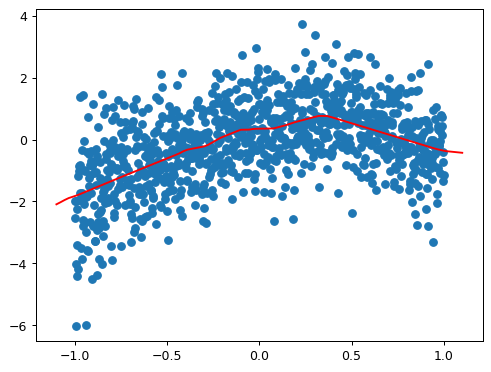

In [21]:
plt.scatter(x, y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-1.1, max=1.1)

### lr scheduler

In [22]:
np.random.seed(42)
hidden_dim = degree * 4
w1 = np.random.randn(hidden_dim, 2)
w2 = np.random.randn(hidden_dim + 1, 1)
w1 = torch.tensor(w1, dtype=torch.float32)
w2 = torch.tensor(w2, dtype=torch.float32)

w1.requires_grad_()
w2.requires_grad_()

lr = 0.01

for i in range(1000):
    loss = compute_mse(w1, w2)
    loss.backward()
    
    with torch.no_grad(): 
        w1 -= (lr*w1.grad)
        w2 -= (lr*w2.grad)
        
        w1.grad.zero_()
        w2.grad.zero_()
        
    if (i+1)%10 == 0:
        lr *= 0.99
        
    if (i+1) % 100 == 0:
#         print(lr)
        print(f"Epoch {i+1} Loss: {loss:.2f}")

Epoch 100 Loss: 1.28
Epoch 200 Loss: 1.23
Epoch 300 Loss: 1.21
Epoch 400 Loss: 1.20
Epoch 500 Loss: 1.19
Epoch 600 Loss: 1.19
Epoch 700 Loss: 1.19
Epoch 800 Loss: 1.18
Epoch 900 Loss: 1.18
Epoch 1000 Loss: 1.18


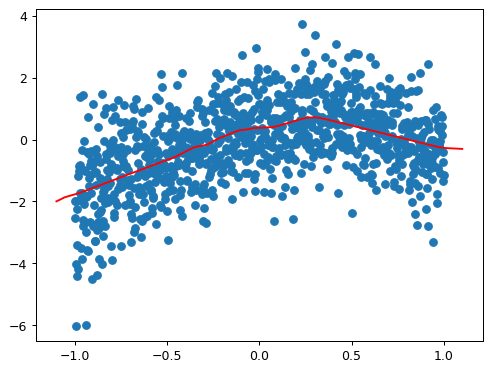

In [23]:
plt.scatter(x, y)
plot_function(partial(multi_relu, w1.detach(), w2.detach()), min=-1.1, max=1.1)

## Using torch nn

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

In [25]:
# Define the neural network model
class SimpleQuadraticNN(nn.Module):
    def __init__(self, degree):
        super(SimpleQuadraticNN, self).__init__()
        self.hidden_dim = degree * 4 + 1 
        self.hidden = nn.Linear(1, self.hidden_dim)  
        self.relu = nn.ReLU()  # ReLU activation
        # Define the output layer with 1 unit
        self.output = nn.Linear(self.hidden_dim, 1)  

    def forward(self, x):
        # Forward pass through the hidden layer and ReLU activation
        x = self.hidden(x)
        x = self.relu(x)
        # Forward pass through the output layer
        x = self.output(x)
        return x

In [26]:
# Create an instance of the model
model = SimpleQuadraticNN(degree=degree)

In [27]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer

In [28]:
def train(model, criterion, optimizer, x_train, y_train, epochs=1000):
    for epoch in range(epochs):
        model.train()
        
        # Convert data to tensors
        x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single feature
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single target
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(x_train_tensor)
        
        # Compute loss
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print loss every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [29]:
train(model, criterion, optimizer, x, y)

/tmp/ipykernel_18/235645135.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single feature
/tmp/ipykernel_18/235645135.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension for single target


Epoch [100/1000], Loss: 1.1766
Epoch [200/1000], Loss: 1.1679
Epoch [300/1000], Loss: 1.1656
Epoch [400/1000], Loss: 1.1628
Epoch [500/1000], Loss: 1.1607
Epoch [600/1000], Loss: 1.1598
Epoch [700/1000], Loss: 1.1596
Epoch [800/1000], Loss: 1.1595
Epoch [900/1000], Loss: 1.1595
Epoch [1000/1000], Loss: 1.1595


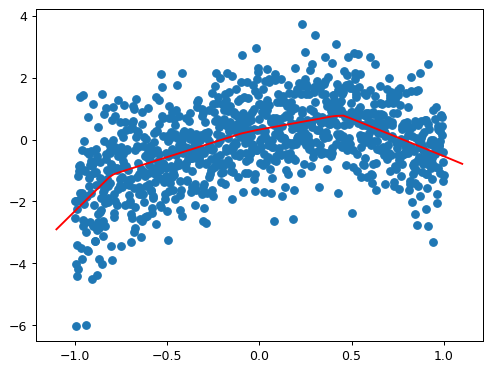

In [30]:
model.eval()  # Set model to evaluation mode
plt.scatter(x,y)

with torch.no_grad():
    plot_function(model, min=-1.1, max=1.1)